## Election data anaylsis, dimensionality reduction and classification

My intention with this notebook was to analyze data by visualization and data manipulation. Then, I performed some dimensionality reduction in order to extract the most pertinent features of the dataset. Finally, I used several machine learning methods to classify the data and assessed these methods for accuracy.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime
from scipy import stats
import copy
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Part 1: Data Analysis

In [2]:
vote_df = pd.read_csv("votes.csv", parse_dates = True)

In [3]:
county_df = pd.read_csv("county_facts.csv")

I want to rename the colummns to names that carry more meaning

In [4]:
county_df = county_df.rename(columns = {"PST045214": "pop2014", "PST040210": "pop2010", "PST120214": "popChange", "AGE135214": "under5", 
                "AGE295214": "under18", "AGE775214": "over65", "SEX255214": "femalePercent", "RHI125214": "whiteAlone", "RHI225214":
                "blackAlone", "RHI325214": "amIndianAlone", "RHI425214": "asianAlone", "RHI625214": "twoRacesPlus", "RHI725214":
                "Latino", "RHI825214": "whiteNotLatino"})

In [5]:
county_df = county_df.rename(columns = {"POP645213": "foreignBorn", "POP815213": "otherLangSpoken", "EDU635213": "highSchoolPlus", 
                           "EDU685213": "bachelorD", "VET605213": "Veteran", "LFE305213": "timeToWork", "HSG010214": 
                            "housingUnits", "HSG445213": "homeownership", "HSG495213": "medianHomeValue", "HSD410213":
                           "Households", "HSD310213": "personsPerHouse"})

In [6]:
county_df = county_df.rename(columns = {"INC910213": "perPersonIncome", "INC110213": "medianHouseIncome", "PVY020213": 
                                       "belowPoverty", "BZA010213": "privateEstablish", "BZA110213": "privateEmploy",
                                       "BZA115213": "privateEmpPercentChange", "NES010213": "nonemployerEstablish",
                                       "SBO001207": "numberFirms", "SBO315207": "blackOwnedFirms", "SBO215207":
                                       "asianOwnedFirms", "SBO415207": "hispanicOwnedFirms", "SBO015207": "womenOwnedFirms"})

In [7]:
county_df = county_df.rename(columns = {"MAN450207": "manufacturShipment", "WTN220207": "merchantSales", "RTN130207": "retailSales",
                           "RTN131207": "retailSalesCapita", "AFN120207": "foodServices", "BPS030214": "buildingPermits",
                           "LND110210": "landAreasqMiles", "POP060210": "popPersqMiles"})

In [8]:
county_df = county_df.dropna()

In [9]:
county_df.isna().sum()

fips                       0
area_name                  0
state_abbreviation         0
pop2014                    0
pop2010                    0
popChange                  0
POP010210                  0
under5                     0
under18                    0
over65                     0
femalePercent              0
whiteAlone                 0
blackAlone                 0
amIndianAlone              0
asianAlone                 0
RHI525214                  0
twoRacesPlus               0
Latino                     0
whiteNotLatino             0
POP715213                  0
foreignBorn                0
otherLangSpoken            0
highSchoolPlus             0
bachelorD                  0
Veteran                    0
timeToWork                 0
housingUnits               0
homeownership              0
HSG096213                  0
medianHomeValue            0
Households                 0
personsPerHouse            0
perPersonIncome            0
medianHouseIncome          0
belowPoverty  

In [10]:
corrMatrix = county_df.corr()
print(corrMatrix.iloc[:, 2])

fips                      -0.056654
pop2014                    0.999629
pop2010                    1.000000
popChange                  0.210098
POP010210                  1.000000
under5                     0.084370
under18                    0.046436
over65                    -0.212340
femalePercent              0.112872
whiteAlone                -0.146605
blackAlone                 0.087093
amIndianAlone             -0.041542
asianAlone                 0.456288
RHI525214                  0.035128
twoRacesPlus               0.122265
Latino                     0.190246
whiteNotLatino            -0.232294
POP715213                 -0.106481
foreignBorn                0.468975
otherLangSpoken            0.311747
highSchoolPlus             0.062075
bachelorD                  0.319975
Veteran                    0.925279
timeToWork                 0.145071
housingUnits               0.993168
homeownership             -0.285304
HSG096213                  0.467999
medianHomeValue            0

This is the correlation for the variable for pop2010. The whole matrix is too large to show. I deleted the columns that I deemed not relevant enough or had too much correlation. Too much correlation between independent variables can lead to multicollinearity. One way to deal with multicolliearity is through principal compoenent analysis, which i will perform latter down.

In [11]:
county_df = county_df.drop(columns = ['POP010210', 'RHI525214', 'POP715213', 'HSG096213', 'SBO115207', 'SBO515207'])

In [12]:
county_df = county_df.drop(columns = ['otherLangSpoken', 'privateEstablish', 'privateEmploy',
                                     'nonemployerEstablish', 'retailSales', 'merchantSales', 
                                      'foodServices', 'buildingPermits'])

I filter the vote_df dataframe to only include relevant columns. Then I merge this dataset with the county demographics dataset.

In [13]:
df1 = vote_df.iloc[:, 3:10]
df2 = vote_df.iloc[:, 12:22]
votes = pd.concat([df1, df2], axis =1)

In [14]:
votes = votes.rename(columns = {"FIPS": "fips"})

In [15]:
df = pd.merge(county_df, votes, how = 'inner', on = 'fips')

I want to create several new columns. One will be for the winner of 2012 and one for winner of 2016 counties. This will be used for classification further down.

In [16]:
def winner(row, candidate1, candidate2):
    if row[candidate1] > row[candidate2]:
        return candidate1
    if row[candidate1] < row[candidate2]:
        return candidate2
    return 'Tie'

In [17]:
df.apply(lambda row: winner(row, 'Clinton', 'Trump'), axis = 1).value_counts()

Trump      2624
Clinton     488
dtype: int64

In [18]:
df.apply(lambda row: winner(row, 'Obama', 'Romney'), axis = 1).value_counts()

Romney    2426
Obama      686
dtype: int64

The first thing to note is the smaller number of counties that democrats win. This underscores the urban-rural divide, whereby the urban vote is biased towards democrats.

In [19]:
df['winner2016'] = df.apply(lambda row: winner(row, 'Clinton', 'Trump'), axis = 1)

In [20]:
df['winner2012'] = df.apply(lambda row: winner(row, 'Obama', 'Romney'), axis = 1)

I create a column that outlines the pattern of votes for the county in 2012 and 2016.

In [21]:
def winnerPattern(row):
    if (row['winner2012'] == 'Obama') & (row['winner2016'] == 'Clinton'):
        return 'DD'
    if (row['winner2012'] == 'Obama') & (row['winner2016'] == 'Trump'):
        return 'DR'
    if (row['winner2012'] == 'Romney') & (row['winner2016'] == 'Clinton'):
        return 'RD'
    if (row['winner2012'] == 'Romney') & (row['winner2016'] == 'Trump'):
        return 'RR'

In [22]:
df.apply(lambda row: winnerPattern(row), axis = 1).value_counts()

RR    2406
DD     468
DR     218
RD      20
dtype: int64

In [23]:
df['winnerPattern'] = df.apply(lambda row: winnerPattern(row), axis = 1)

In [24]:
df['dem_per_gain'] = df['per_point_diff_2016'] - df['per_point_diff_2012']

Next, I will create a column for determining if the county voted more for republican or more for democrat, compared to the
2012 election. As shown below, there were gains for republicans much more than democrats. 

In [25]:
def demPerGain(row):
    if row['dem_per_gain'] > 0:
        return 'demGain'
    return 'repGain'

In [26]:
df.apply(lambda row: demPerGain(row), axis = 1).value_counts()

repGain    2724
demGain     388
dtype: int64

In [27]:
df['who_gained'] = df.apply(lambda row: demPerGain(row), axis = 1)

In [28]:
demGain = df[df['who_gained'] == 'demGain']

In [29]:
demGain[['who_gained', 'state_abbreviation']].groupby('state_abbreviation').count().sort_values(by = 'who_gained', ascending = False)

,who_gained
state_abbreviation,
TX,62
CA,36
UT,27
VA,27
GA,26
ID,16
CO,14
FL,13
NC,13


Looking at the state by state breakdown Texas has the largest number of changes in part because of its size. As well, there has been significant demographic change over the years, so this could represent a shift in demographics more than certain demographics switching their vote. There are some swing states that have changed, but it is mostly non-swing states making gains for democrats relateively inefficient. I'll look further into this further down.

In [30]:
repGain = df[df['who_gained'] == 'repGain']

In [31]:
repGain[['who_gained', 'state_abbreviation']].groupby('state_abbreviation').count().sort_values(by = 'who_gained', ascending = False)

,who_gained
state_abbreviation,
TX,192
GA,133
KY,115
MO,112
VA,106
IA,97
KS,94
IL,93
TN,91


This is similar to democrat gains, in that most are not swing states.

In [32]:
changedSwingStates = ['FL', 'PA', 'OH', 'MI', 'WI', 'IA']
unchangedSwingStates = ['VA', 'CO']
democraticStrong = ['CA', 'CT', 'DE', 'DC', 'HI', 'IL', 'MD', 'MA', 'NY', 'OR', 'VT', 'WA']
republicanStrong = ['AL', 'AR', 'ID', 'KS', 'KY', 'LA', 'MT', 'NE', 'ND', 'OK', 'TN', 'WY']

I want to look at the swing states that ended up changing from democrat to republican to the states that were similarly close in 2012, but did not change to republican. These states are Virginia and Colorado. I'd like to see if there are similar shifts in certain demographics or if changing demographics meant that Colorado and Virginia stayed, while the others did not.

In [33]:
def state_category(row):
    if row['state_abbreviation'] in changedSwingStates :
        return 'changed'
    if row['state_abbreviation'] in unchangedSwingStates:
        return 'unchangedSwing'
    if row['state_abbreviation'] in democraticStrong:
        return 'democrat'
    if row['state_abbreviation'] in republicanStrong:
        return 'republican'
    return 'normal state'

In [34]:
df.apply(lambda row: state_category(row), axis = 1).value_counts()

normal state      1202
republican         872
changed            476
democrat           365
unchangedSwing     197
dtype: int64

In [35]:
df['stateChanged'] = df.apply(lambda row: state_category(row), axis = 1)

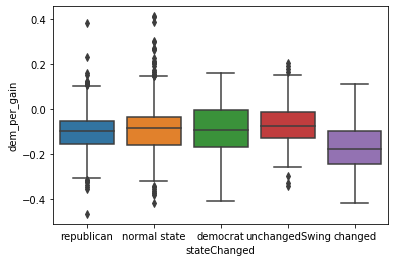

In [36]:
sns.boxplot(x= "stateChanged", y = "dem_per_gain", data = df)

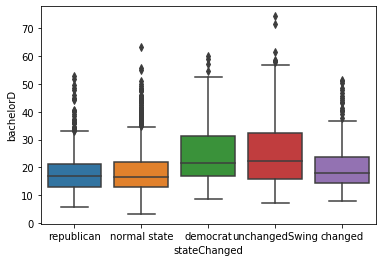

In [37]:
sns.boxplot(x= "stateChanged", y = "bachelorD", data = df)

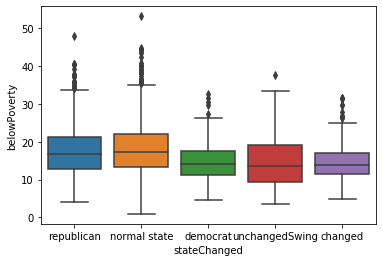

In [38]:
sns.boxplot(x= "stateChanged", y = "belowPoverty", data = df)

The democratic strongholds have significantly more educated counties than republicans. As well, the unchanged swing states had a more educated population than the ones that were changed.

One thing to note is the outliers in the demograpics. There are many ways to deal with outliers, and sometimes not eliminating them is an obtion. Others options iclude using z-score to rescale the data  and logging the variables to normalize the distribution.

I will treat these outliers using the z-score functon. The z score function rescales the data such that it is centred. If there are any data points that are too far from the center, for example 3 z scores from the mean, then they are removed. 

In [39]:
z = np.abs(stats.zscore(df.iloc[:, 3:40]))

In [40]:
threshold = 3
len(np.where(z >3 )[0])

1740

There are too many outliers. I will do a test on each column and estimate each column. If it is not normally distributed I will log that column. i will use the shapiro-wilk test to test for normality. If the null hypothesis is rejected, this means that it is likely that the distribution is not normal.

In [41]:
stat, p = shapiro(df.iloc[:, 3:41])

C:\Users\pruss\anaconda3\envs\pandas_playground\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [42]:
dem_labels = df.iloc[:, 3:40].columns

In [43]:
demographics_df = df.iloc[:, 3:40]

In [44]:
nonnormal = []

In [45]:
for i in dem_labels:
    stat, p = shapiro(df[i])
    if p < .05:
        nonnormal.append(i)

In [46]:
len(nonnormal)

37

All columns are estimated to not be normal, therefore I will try logging. Before logging all columns, I note that popChange and privateEmpPercentChange have negative values. Thus, I must adjust them. To do so, I add a value to each such that the minimum value is positive.

Two of the columns have negative values which cannot be logged. I will add each value of these columns by the minimum + .1 to ensure all numbers are positive.

In [47]:
df['popChange'].min()

-17.0

In [48]:
df['privateEmpPercentChange'].min()

-71.5

In [49]:
log_df = copy.copy(df)

In [50]:
log_df['popChange'] = df['popChange'] + 17.1

In [51]:
log_df['privateEmpPercentChange'] = df['privateEmpPercentChange'] +71.6

In [52]:
for i in dem_labels:
    log_df[i] = np.log(log_df[i])

C:\Users\pruss\anaconda3\envs\pandas_playground\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
log_df.describe()

,fips,pop2014,pop2010,popChange,under5,under18,over65,femalePercent,whiteAlone,blackAlone,...,total_votes_2012,votes_dem_2012,votes_gop_2012,county_fips,state_fips,Obama,Romney,diff_2012,per_point_diff_2012,dem_per_gain
count,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,...,3.112000e+03,3.112000e+03,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000
mean,30651.700514,10.285221,10.281551,2.839496,1.752869,3.104176,2.839207,3.910052,4.421896,-inf,...,3.950556e+04,1.999004e+04,18890.392352,30651.700514,30.548522,0.384943,0.597833,9565.503535,-0.212890,-0.106192
std,14984.654885,1.471504,1.455853,0.235553,0.200802,0.149700,0.251892,0.047971,0.254173,NaN,...,1.056297e+05,6.599190e+04,41731.449644,14984.654885,14.965305,0.148024,0.147614,36023.739788,0.295500,0.102459
min,1001.000000,4.454347,4.406719,-2.302585,0.405465,2.001480,1.410987,3.404525,1.774952,-inf,...,6.400000e+01,5.000000e+00,54.000000,1001.000000,1.000000,0.034483,0.060064,1.000000,-0.924138,-0.467582
25%,19038.500000,9.319889,9.333398,2.714695,1.648659,3.020425,2.694627,3.901973,4.390739,-0.223144,...,4.765750e+03,1.555000e+03,2889.750000,19038.500000,19.000000,0.278024,0.507527,1047.750000,-0.425556,-0.174463
50%,29208.000000,10.164351,10.167792,2.827314,1.757858,3.109061,2.850707,3.919991,4.521789,0.875469,...,1.073250e+04,3.948500e+03,6393.500000,29208.000000,29.000000,0.371711,0.609411,2565.500000,-0.238108,-0.100592
75%,46005.500000,11.130574,11.113839,2.960105,1.871802,3.186353,2.991973,3.933784,4.564348,2.388763,...,2.762825e+04,1.110025e+04,15948.750000,46005.500000,46.000000,0.475297,0.703178,6473.000000,-0.032239,-0.043554
max,56045.000000,16.129699,16.099796,4.499810,2.587764,3.701302,3.968403,4.039536,4.598146,4.443827,...,2.427869e+06,1.672164e+06,699600.000000,56045.000000,56.000000,0.933546,0.958621,972564.000000,0.873482,0.412087


It seems that the mean and median are significantly closer than the non-logged dataframe. This means that the columns are more closely normally distributed.

In [54]:
lognormal = []

In [55]:
for i in dem_labels:
    stat, p = shapiro(log_df[i])
    if p < .05:
        lognormal.append(i)

In [56]:
len(lognormal)

25

So, I can't really normalize the data by logging it. Normality isn't necessary to create an accurate model, but re-scaling should be performed and I will do that, when I implement the machie learning methods.

Next, I want to create a column for each county-candidate pair, as I want to graph votes for candidates as a function of demographic variables.

In [57]:
obamadf = copy.copy(df)
romneydf = copy.copy(df)
clintondf = copy.copy(df)
trumpdf = copy.copy(df)

In [58]:
obamadf['candidate'] = 'Obama'
romneydf['candidate'] = 'Romney'
clintondf['candidate'] = 'Clinton'
trumpdf['candidate'] = 'Trump'

In [59]:
df2 = pd.concat([obamadf, romneydf, clintondf, trumpdf], axis = 0)

In [60]:
df2 = df2.sort_values(by = 'fips')

In [61]:
def vote_percent(row):
    if row['candidate'] == 'Obama':
        return row['Obama']
    if row['candidate'] == 'Romney':
        return row['Romney']
    if row['candidate'] == 'Clinton':
        return row['Clinton']
    if row['candidate'] == 'Trump':
        return row['Trump']

In [62]:
df2['vote_percent'] = df2.apply(lambda row: vote_percent(row), axis = 1)

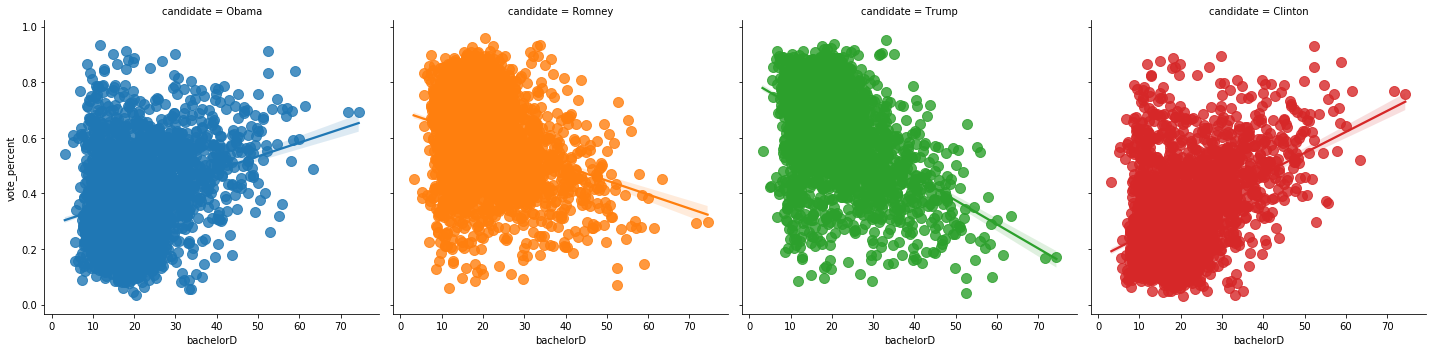

In [63]:
sns.lmplot(x = "bachelorD", y = "vote_percent", hue =  'candidate', col = 'candidate', data = df2, scatter_kws={"s": 100})

Republican success correlates with a less educated populace. Democrats find success with more educated populace. This effect is exacerbated in 2016, with Trump having a less educated support.

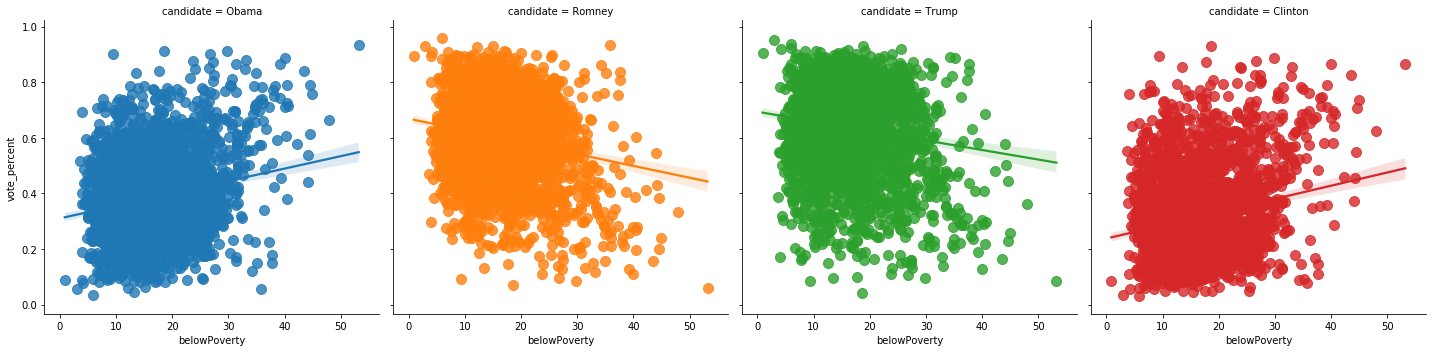

In [64]:
sns.lmplot(x = "belowPoverty", y = "vote_percent", hue =  'candidate', col = 'candidate', data = df2, scatter_kws={"s": 100})

Create a function that creates a pivot table with winnerPattern as the index, and calculates median for a specified demographic. i will then create a table that stores each demographic.

In [65]:
def new_pivot(data, values, index = ['winnerPattern'], aggfunc = np.median, margins = True):
    new_pivot = data.pivot_table(values = values, index = index, aggfunc = aggfunc, margins = True)
    return new_pivot

In [66]:
df_white = new_pivot(df2, values = 'whiteAlone')

In [67]:
df_white

,whiteAlone
winnerPattern,
DD,74.75
DR,92.30
RD,85.90
RR,93.45
All,92.00


In [68]:
changed_median_df = pd.DataFrame()

In [69]:
demographics = df2.iloc[:, 3:40].columns

In [70]:
for i in demographics:
    new_df = new_pivot(df2, i)
    changed_median_df = pd.concat([changed_median_df, new_df], axis=1)

In [71]:
changed_median_df.iloc[:, 1:20]

,pop2010,popChange,under5,under18,over65,femalePercent,whiteAlone,blackAlone,amIndianAlone,asianAlone,twoRacesPlus,Latino,whiteNotLatino,foreignBorn,highSchoolPlus,bachelorD,Veteran,timeToWork,housingUnits
winnerPattern,,,,,,,,,,,,,,,,,,,
DD,93530.0,1.25,6.0,22.15,14.50,51.0,74.75,11.65,0.60,1.80,2.10,6.25,51.85,6.25,86.80,27.50,6787.5,22.95,41035.5
DR,33096.0,-1.00,5.4,21.60,18.10,50.3,92.30,2.20,0.50,0.70,1.60,3.10,85.70,2.30,88.15,17.85,2802.0,22.00,16471.5
RD,392276.5,4.75,6.2,24.05,11.35,50.2,85.90,4.25,0.75,4.45,2.45,10.40,71.75,9.25,89.55,36.95,22936.0,23.15,160230.5
RR,22601.5,-0.40,5.8,22.60,17.80,50.3,93.45,1.90,0.60,0.60,1.50,3.60,87.20,2.10,85.40,16.80,1754.5,22.90,10660.0
All,26050.5,-0.20,5.8,22.40,17.30,50.4,92.00,2.40,0.60,0.60,1.60,3.90,84.70,2.50,85.90,17.50,2041.5,22.80,12497.5


There seems to be greater similarity between the demographics of those counties that switched to republican and those that voted republican both times. This indicates that Obama was able to win counties that were more demographically oriented towards the average republican, and that Clinton could not continue this. Perhaps there were demographic changes between 2012 and 2016 that made it more likely certain counties would switch, even if Obama and Clinton shared the same percentage amongst those demographics.

The similarities are more prominent in factors estimating the level of urban vs. rural (popChange, popPersqMiles), african american (blackAlone) and education (bachelorD). This also hints at a growing divide between democrats and republicans.

In [72]:
who_gained_df = pd.DataFrame()

In [73]:
for i in demographics:
    stateChanged_df = new_pivot(df2, i, index = ['stateChanged'])
    who_gained_df = pd.concat([who_gained_df, stateChanged_df], axis=1)

In [74]:
who_gained_df.iloc[:,:]

,pop2014,pop2010,popChange,under5,under18,over65,femalePercent,whiteAlone,blackAlone,amIndianAlone,...,privateEmpPercentChange,numberFirms,blackOwnedFirms,asianOwnedFirms,hispanicOwnedFirms,womenOwnedFirms,manufacturShipment,retailSalesCapita,landAreasqMiles,popPersqMiles
stateChanged,,,,,,,,,,,,,,,,,,,,,
changed,42567.0,42772.5,-0.7,5.5,21.85,18.00,50.3,94.8,1.8,0.4,...,0.60,3428.0,0.0,0.0,0.0,24.10,584290.5,10468.0,570.315,71.50
democrat,63067.0,63461.0,-0.1,5.4,21.50,17.20,50.3,90.6,2.2,0.6,...,0.90,5268.0,0.0,0.0,0.0,27.70,535756.0,11060.0,693.270,76.10
normal state,25182.5,25204.5,-0.1,6.0,23.00,16.80,50.5,90.7,3.8,0.6,...,0.60,1952.5,0.0,0.0,0.0,22.85,0.0,9688.5,593.795,43.90
republican,16414.0,16545.5,-0.3,6.0,23.00,17.65,50.3,93.7,1.6,0.7,...,0.95,1331.5,0.0,0.0,0.0,20.20,0.0,8785.5,666.745,28.95
unchangedSwing,22524.0,22709.0,0.9,5.2,20.50,17.60,50.4,87.8,6.9,0.5,...,0.10,1927.0,0.0,0.0,0.0,25.40,0.0,10026.0,423.300,65.50
All,25961.0,26050.5,-0.2,5.8,22.40,17.30,50.4,92.0,2.4,0.6,...,0.70,2177.0,0.0,0.0,0.0,23.20,0.0,9734.5,611.010,45.70


Separating the counties by how likely the states were to vote democrat or republican, it is clear that popChange divides the swing states that did change to republican (changed) and the unchanged swing states. As shown in the previous chart counties most likely to vote republican or switch to republican had a negative population change, perhaps showing the rural urban divide. The swing states that did not change did not have negative population change, while the changed swing states had negative population change.

Looking at the whiteAlone column, the swing states that did not change had the lowest white percentage, while those that did had the highest percentage of white persons. This is mirrored by the blackAlone column that has significantly higher numbers for unchanged swing states.

The education level also had noticeable differences between those two types of states. Unchanged states had the highest bachelor's degree percentage, while the changed states had numbers much closer to the republican states.

In [75]:
who_gained_df = pd.DataFrame()

In [76]:
for i in demographics:
    gain_df = new_pivot(df2, i, index = ['who_gained'])
    who_gained_df = pd.concat([who_gained_df, gain_df], axis=1)

In [77]:
who_gained_df.iloc[:, :]

,pop2014,pop2010,popChange,under5,under18,over65,femalePercent,whiteAlone,blackAlone,amIndianAlone,...,privateEmpPercentChange,numberFirms,blackOwnedFirms,asianOwnedFirms,hispanicOwnedFirms,womenOwnedFirms,manufacturShipment,retailSalesCapita,landAreasqMiles,popPersqMiles
who_gained,,,,,,,,,,,,,,,,,,,,,
demGain,172455.0,158286.5,4.4,6.4,23.9,12.8,50.6,86.0,4.9,0.8,...,2.05,14200.0,1.0,1.95,2.2,27.50,1073553,13146.0,728.685,297.60
repGain,23081.5,23354.0,-0.6,5.8,22.3,17.8,50.4,92.8,2.2,0.5,...,0.40,1863.5,0.0,0.00,0.0,22.35,0,9271.0,601.855,41.15
All,25961.0,26050.5,-0.2,5.8,22.4,17.3,50.4,92.0,2.4,0.6,...,0.70,2177.0,0.0,0.00,0.0,23.20,0,9734.5,611.010,45.70


Next, I broke down counties into the ones that saw a percentage gain for the democrats and those that saw a percentage gain for the GOP. As previously thought, increased population change meant a more likely democratic gain. Predominantly white counties were more likely to gain for republicans and the opposite is true for african americans. 

Foreign born voters were more likely to vote democratic. As well, more educated counties were more likely to switch to democrats, as evidenced by bechelorD and highSchoolPlus. The homeownership numbers most likely hint at the younger democraphic that the democrats attract.

Next I want to calculate the overall loss or gain for democrats by state.

In [78]:
state_vote = df[['state_abbreviation', 'votes_dem_2016', 'votes_gop_2016', 'total_votes_2016', 'votes_dem_2012', 'votes_gop_2012', 'total_votes_2012']].groupby('state_abbreviation').sum()

In [79]:
state_vote

,votes_dem_2016,votes_gop_2016,total_votes_2016,votes_dem_2012,votes_gop_2012,total_votes_2012
state_abbreviation,,,,,,
AL,718084,1306925,2078165,793620,1252453,2064699
AR,378729,677904,1108615,391953,643717,1062831
AZ,936250,1021154,2062810,900081,1107130,2041519
CA,7230699,3841134,11733523,6241648,4046524,10538656
CO,1212209,1137455,2564185,1238490,1125391,2419698
CT,884432,668266,1623542,912531,631432,1562187
DC,260223,11553,280272,222332,17337,243348
DE,235581,185103,441535,242547,165476,413844
FL,4485745,4605515,9386750,4235270,4162081,8470205


In [80]:
def pos_to_neg(row):
    if row['Clinton'] < row['Trump']:
        return -row['diff_2016']
    return row['diff_2016']

In [81]:
def pos_to_neg_2012(row):
    if row['Obama'] < row['Romney']:
        return -row['diff_2012']
    return row['diff_2012']

In [82]:
df['overall_dem_loss_2016'] = df.apply(lambda row: pos_to_neg(row), axis = 1)

In [83]:
df['overall_dem_loss_2012'] = df.apply(lambda row: pos_to_neg_2012(row), axis = 1)

In [84]:
state_vote = df[['state_abbreviation', 'votes_dem_2012', 'votes_gop_2012', 'total_votes_2012', 'votes_dem_2016', 'votes_gop_2016', 'total_votes_2016']].groupby('state_abbreviation').sum()

In [85]:
state_vote['overall gain dem'] = ((state_vote['votes_dem_2016'] - state_vote['votes_gop_2016']) /state_vote['total_votes_2016'])- (state_vote['votes_dem_2012'] - state_vote['votes_gop_2012'])/ state_vote['total_votes_2012']

In [86]:
state_vote.sort_values(by = 'overall gain dem')

,votes_dem_2012,votes_gop_2012,total_votes_2012,votes_dem_2016,votes_gop_2016,total_votes_2016,overall gain dem
state_abbreviation,,,,,,,
ND,124490,187586,319825,93526,216133,336968,-0.166571
WV,234925,412406,661643,187457,486198,708226,-0.153573
IA,816429,727928,1565968,650790,798923,1542880,-0.152526
ME,397754,290437,710738,354873,334838,741550,-0.123976
SD,144988,210541,363695,117442,227701,370047,-0.117718
RI,274342,155355,437380,249902,179421,450121,-0.115463
HI,303090,119494,429494,266827,128815,428825,-0.105633
OH,2697260,2593779,5379090,2317001,2771984,5325395,-0.104674
MI,2561911,2112673,4717728,2268193,2279805,4790917,-0.097647


From the changes in percentage votes, it appears that the losses for democrats are not very localized. Some states that saw huge democratic losses were republican strongholds, and some were democratic strongholds. While, some in which they gained were democratic or republican strongholds. 

I want to create a column that encodes 1 for swing state and 0 for a non swing state.

In [87]:
def swing(row, list):
    if(row['state_abbreviation'] in list):
        return 1
    return 0

In [88]:
swing_list = ['FL', 'NC', 'OH', 'VA', 'CO', 'PA', 'NH', 'IA', 'NV', 'WI', 'MN', 'GA', 'AZ', 'MO', 'MI']

In [89]:
df2['swingState'] = df2.apply(lambda row: swing(row, swing_list), axis = 1)

In [90]:
df_DR = df[df['winnerPattern'] == 'DR']
d = df_DR[['winnerPattern', 'state_abbreviation']].groupby(['state_abbreviation']).count().sort_values(by = 'winnerPattern', ascending = False)
d = d.reset_index()

In [91]:
d['swingState'] = d.apply(lambda row: swing(row, swing_list), axis = 1)

In [92]:
d.sort_values(by = 'swingState', ascending = False)

,state_abbreviation,winnerPattern,swingState
0,IA,31,1
8,NC,7,1
22,NH,3,1
21,PA,3,1
1,WI,22,1
16,CO,4,1
11,GA,6,1
9,VA,7,1
17,FL,4,1
6,OH,9,1


In [93]:
len(d[d['swingState'] == 1]) / len(d)

0.34285714285714286

In [94]:
(len(df2[df2['swingState'] == 1])/4)/ len(df)

0.37789203084832906

Of the counties that switched from democrat to republican, 34 percent were in swing states. In total, ~38 percent of counties are located in swing states. Therefore, it appears there was not substantial increases in republican support in swing states, relative to non-swing states. 

Next, I will look at changes in counties by percentage, rather than the categorical manner previously.

In [95]:
df2['percent_gain_dem'] = df2['per_point_diff_2016'] - df2['per_point_diff_2012']

In [96]:
df2.nlargest(200, 'percent_gain_dem')['state_abbreviation'].value_counts()

UT    76
VA    40
TX    20
GA    16
CA    16
ID    12
IL     4
WY     4
IN     4
NM     4
KS     4
Name: state_abbreviation, dtype: int64

I found the counties with the largest democratic gain and from what states they come from. The large gains in Utah are due to Romney not being the candidate in 2016.I will just filter out Utah.

In [97]:
df2 = df2[df2.state_abbreviation != 'UT']

In [98]:
big_dem_gain = df2.nlargest(200, 'percent_gain_dem')

In [99]:
big_dem_loss = df2.nsmallest(200, 'percent_gain_dem')

In [100]:
big_dem_gain[['fips', 'state_abbreviation']].groupby('state_abbreviation').count().sort_values(by = 'fips', ascending = False)

,fips
state_abbreviation,
VA,40
TX,36
CA,28
ID,24
GA,20
IL,12
MA,8
MD,8
IN,4


In [101]:
big_dem_loss[['fips', 'state_abbreviation']].groupby('state_abbreviation').count().sort_values(by = 'fips', ascending = False)

,fips
state_abbreviation,
IA,52
OH,44
MO,24
TN,20
IL,8
IN,8
KY,8
VA,8
WI,8


So, 48/ 200 = 24% of counties in which democrats made their largest gains were in swing states (not counting Utah). While 120/200 = 60% percent of counties in which republicans made their largest gains were in swing states. From this angle, it appears that republicans were efficient in their gains in that it came from swing states that have a disproportionate effect on the outcome of the election. 

Next I want to determine the voting turnout and whether certain key demographics altered from 2012 to 2016.

In [102]:
halfpopChange = df2['popChange']/2/100+1

In [103]:
df2['pop2012'] = df2.loc[:, 'pop2010']*halfpopChange

In [104]:
under18 = (100-df2['under18'])/100

In [105]:
df2['votingAge2012'] = df2.loc[:, 'pop2012']*under18

In [106]:
df2['pop2016'] = df2['pop2014']*halfpopChange

In [107]:
df2['votingAge2016'] = df2['pop2014']*under18

In [108]:
df2['turnout2012'] = (df2.loc[:, 'total_votes_2012'] / df2.loc[:, 'votingAge2012'])*100

In [109]:
df2['turnout2016'] = (df2.loc[:, 'total_votes_2016'] / df2.loc[:, 'votingAge2016'])*100

In [110]:
df2['swingState'].value_counts()

0    7628
1    4704
Name: swingState, dtype: int64

In [111]:
df2['turnoutChange'] = df2['turnout2016'] - df2['turnout2012']

In [112]:
turnoutChange2016 = pd.pivot_table(data = df2, index = 'swingState', columns = 'winner2016', values = 'turnoutChange', aggfunc = np.median, margins = True)

In [113]:
turnoutChange2016

winner2016,Clinton,Trump,All
swingState,,,
0,0.377142,1.789764,1.662567
1,-1.029211,1.214164,0.961834
All,-0.209817,1.588693,1.395125


In [114]:
turnoutChange2012 = pd.pivot_table(data = df2, index = 'swingState', columns = 'winner2012', values = 'turnoutChange', aggfunc = np.median, margins = True)

In [115]:
turnoutChange2012

winner2012,Obama,Romney,All
swingState,,,
0,0.400014,1.827583,1.662567
1,-0.890693,1.513911,0.961834
All,-0.325132,1.717055,1.395125


So, the counties that Clinton won saw a decline in voter turnout when it was a swing state. Trump saw an increase in voter turnouot for both swing state and non-swing states. It's possible that the counties that normally vote for democrats had less voter turnout and the ones that normally vote GOP had higher turnout than normal. This effect was strongest in the swing states.

In [116]:
turnout_demographics = pd.concat([df2.iloc[:, 3:43], df2['turnoutChange'], df2['swingState'], df2['stateChanged']], axis = 1)

In [117]:
turnout_corr = turnout_demographics.corr()

In [118]:
turnout_corr.loc[:, 'turnoutChange'].sort_values()

blackAlone                -0.328612
blackOwnedFirms           -0.212409
belowPoverty              -0.190732
under5                    -0.168099
amIndianAlone             -0.122100
under18                   -0.089621
swingState                -0.043275
femalePercent             -0.016415
landAreasqMiles           -0.001147
manufacturShipment         0.016915
retailSalesCapita          0.019685
over65                     0.027316
womenOwnedFirms            0.034597
popPersqMiles              0.040559
personsPerHouse            0.042721
twoRacesPlus               0.051450
votes_dem_2016             0.051692
hispanicOwnedFirms         0.052355
asianOwnedFirms            0.052704
Latino                     0.055427
highSchoolPlus             0.064513
Households                 0.064906
privateEmpPercentChange    0.065023
pop2010                    0.066489
pop2014                    0.067797
housingUnits               0.067818
numberFirms                0.071870
Veteran                    0

blackAlone and belowPoverty have the lowest correlation indicating that low turnout could have been a contributing factor in the democrat loss. This is mirrored by whiteAlone. There was no decline in bachelor's degree or popChange. This indicates that despite urban areas and higher education being important factors for the democrats, there was no lack of voter turnout that can explain the loss. However, their uptick in higher turnout was eclipsed by whiteAlone, a good predictor of republican success.

In [119]:
typeOfState = turnout_demographics['stateChanged'].unique()

In [120]:
turnout_corr = pd.DataFrame()

In [121]:
for i in typeOfState:
    turnout = turnout_demographics[turnout_demographics['stateChanged'] == i]
    turnout = turnout.corr().loc[:, 'turnoutChange']
    turnout_corr = pd.concat([turnout_corr, turnout], axis = 1)

In [122]:
turnout_corr.columns = ['republican', 'normal', 'democrat', 'nochangeSwing', 'changedSwing']

In [123]:
turnout_corr

,republican,normal,democrat,nochangeSwing,changedSwing
pop2014,0.003458,0.056256,0.075410,-0.005557,0.113550
pop2010,-0.000362,0.055174,0.075408,-0.005047,0.106539
popChange,0.051330,0.197500,0.079976,0.025406,0.232937
under5,-0.107019,-0.224280,0.025892,-0.188409,-0.270915
under18,-0.005616,-0.128784,0.031158,-0.002176,-0.270339
over65,-0.066463,0.064896,-0.068953,0.035206,0.196960
femalePercent,-0.031490,-0.000559,0.037109,-0.156471,0.007362
whiteAlone,0.328713,0.451593,0.037664,0.470380,0.004130
blackAlone,-0.356943,-0.400188,-0.090600,-0.459998,0.081137
amIndianAlone,-0.036236,-0.193804,-0.063824,-0.012960,-0.144532


Despite there being a significant decline in voter turnout amongst blacks, this did not appear to contribute to the losses and retentions in the swing states for the democrats. blackAlone had a significant negative correlation with the swing states retained by the democrats, while a neglible positive correlation in the swing states lost. 

Despite the more educated populace having increased voter turnout,  this does not occur in the swing states. The swing states that were lost by democrats had a negative correlation (although minimal) and the ones retained had a minimal positive correlation. 

It is a similar story for urban voters and white vote, in that the correlation is opposite one might expect given what states the democrats retained and lost. 

The loss in comparative voter turnout for the democrats appeared to occur in non swing states in that black turnout went down substantially in republican and normal states. This is similar for below the poverty level. 

Next I want to try some different techniques to understand the data better. First I want to use princial component analysis.
This is a technique that forms new variables from the original variables such that the variance is maximized. New variables are linear combinations of the original variables. This technique helps reduce the dimensionality and is thus most useful the more variables are present in the dataset. It can also help against multicollinearity as each subsequent new variable must be orthognal to the previous one constructed.

In order to perform principal component analysis, I want to scale the data such that certain variables are not given 
disproportionate weight simply because they have numbers on a larger scale. 


In [124]:
demographics = df.iloc[:, 3:40]

In [125]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [126]:
X = demographics

In [127]:
y = df.loc[:, "winner2016"]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .8, random_state = 1)

In [129]:
sc = StandardScaler()

In [130]:
X_train = sc.fit_transform(X_train)

In [131]:
X_test = sc.fit_transform(X_test)

In [132]:
pca = PCA(n_components = 37)

In [133]:
X_train = pca.fit_transform(X_train)

In [134]:
X_test = pca.fit_transform(X_test)

In [135]:
explained_variance = pca.explained_variance_ratio_

In [136]:
explained_variance

array([2.64120381e-01, 1.48765535e-01, 9.34771920e-02, 7.30012454e-02,
       4.98136105e-02, 4.88389963e-02, 3.98533897e-02, 3.05686909e-02,
       2.86021921e-02, 2.59600895e-02, 2.53951472e-02, 2.47041642e-02,
       1.83284463e-02, 1.69331376e-02, 1.54567273e-02, 1.46779802e-02,
       1.21097627e-02, 1.16129381e-02, 8.98762101e-03, 7.15038981e-03,
       7.04483532e-03, 6.27844471e-03, 5.45611024e-03, 4.84540745e-03,
       3.73964503e-03, 3.28321158e-03, 2.60406083e-03, 2.47509353e-03,
       2.29659946e-03, 2.04780559e-03, 1.11324180e-03, 3.01782797e-04,
       1.11682352e-04, 2.34363401e-05, 1.11595981e-05, 6.42922824e-06,
       3.41773311e-06])

In [137]:
var1=np.cumsum(np.round(explained_variance, decimals=4)*100)

In [138]:
var1

array([ 26.41,  41.29,  50.64,  57.94,  62.92,  67.8 ,  71.79,  74.85,
        77.71,  80.31,  82.85,  85.32,  87.15,  88.84,  90.39,  91.86,
        93.07,  94.23,  95.13,  95.85,  96.55,  97.18,  97.73,  98.21,
        98.58,  98.91,  99.17,  99.42,  99.65,  99.85,  99.96,  99.99,
       100.  , 100.  , 100.  , 100.  , 100.  ])

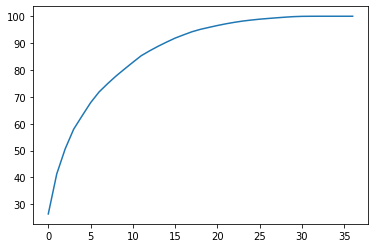

In [139]:
plt.plot(var1)

Looking at the cumulative sum of the variance explained of. each component, I will choose the variables such that 80 percent of the variance is explained

In [140]:
X_train = X_train[:, :10]

In [141]:
X_test = X_test[:, :10]

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [143]:
classifier = LogisticRegression(random_state = 1)

In [144]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [145]:
y_pred = classifier.predict(X_test)

In [146]:
cm = confusion_matrix(y_test, y_pred)

In [147]:
cm

array([[ 200,  189],
       [ 140, 1961]], dtype=int64)

In [148]:
cm[0][0]

200

In [149]:
success = (cm[0][0] + cm[1][1])/len(y_test)

In [150]:
success

0.8678714859437751

In [151]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Clinton       0.59      0.51      0.55       389
       Trump       0.91      0.93      0.92      2101

    accuracy                           0.87      2490
   macro avg       0.75      0.72      0.74      2490
weighted avg       0.86      0.87      0.86      2490



The classification report includes more metrics than just the accuracy score. For instance precision is equal to true positive divided by true positive plus false positives. It essentially measures how many instances that were predicted to be positive were actually positive. Recall is defined as true positive divided by true positives plus false negatives. It is equivalent to measuring how many were positive were predicted to be positive. 

There is noticeably worse scores for Clinton, the minority class. One way to deal with this is resampling techniques, whereby I can reduce the number of instances from the majority class or artificially increase the numbers from the minority class. I won't go down that path this notebook, but I do try these techniques in the credit card notebook.

The relevancy of these different metrics are made more clear by looking at the example of fraud detection. The fast number of transactions are not fraudlent, so a method could churn out 99 percent accuracy for just predicting all transactions are non-fraudaulent, but this lagorithm would tell us nothing. Recall would be a better metric in this instance.

So taking the true positives and true negatives and dividing by the total number of cases, the success rate is 86 percent. I want to compare this to regression that includes 1 to the maximum number of components. I'll create a function for this.

In [152]:
def pcr(x, y, com):
    pc_results = pd.DataFrame()
    pca = PCA()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .8, random_state = 1)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    pca = PCA(n_components = com)
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)
    classifier = LogisticRegression(random_state = 1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    overall_success = ((cm[0][0] + cm[1][1])/len(y_test))*100
    pc_results = pd.DataFrame({'number of components': i, 'True Positives': [cm[0][0]], 'False Positives': [cm[0][1]], 'False Negatives': [cm[1][0]], 'True Negatives': [cm[1][1]], 'Success Rate': overall_success})
    return pc_results

In [153]:
X = demographics
y = df.loc[:, "winner2016"]

In [154]:
results = pd.DataFrame()
for i in range(1, 37):
    pc_results = pcr(X, y, i)
    results = pd.concat([results, pc_results], axis = 0, ignore_index = True)

In [155]:
results

,number of components,True Positives,False Positives,False Negatives,True Negatives,Success Rate
0,1,120,269,32,2069,87.911647
1,2,146,243,35,2066,88.835341
2,3,145,244,36,2065,88.755020
3,4,195,194,57,2044,89.919679
4,5,205,184,164,1937,86.024096
5,6,208,181,167,1934,86.024096
6,7,213,176,145,1956,87.108434
7,8,211,178,136,1965,87.389558
8,9,200,189,140,1961,86.787149
9,10,200,189,140,1961,86.787149


Principal component analysis can be thought of as a type of regularization in that some features in weighed more heavily than others. The level of weight is determined by how highly that feature explains variance in the data. When you create a model, if there is not a lot of complexity (not many features) then the bias will be high and the variance will be low. While if the complexity is high variance will be high and bias will be low. 

When there is high variance, this is called overfitting where the relationship predicted by the training set does not correctly predict the relationship in another subset of the dataset (test set). In a linear regression, the sum of squared errors will vary widely from one subset to another. 

With high bias, the simplicity of the relationship mapped cannot accurately predict the test set, but the error will be more consistent across different subsets of the data.

In the above table, the optimal number of components is 4, as it maximizes the success rate. This is because the cost of bias and variance is minimized.

The false positive column starts high and then decreases around 5 or 6 components. The high numbers in the beginning reflect the effect of high bias. The model predicted much more Clinton victories than was true. It failed to understand the true relationship. The false negative column starts low and immediately increases, just like what occurs with variance in an increasingly complex model. 

I want to compare these results to a logisitic regression model that does not use pca. I'll do that soon. First, I want to check out the factor loadings, which essentially how much an original variable contributes to that latent factor.

In [156]:
X = sc.fit_transform(X)

In [157]:
pca = PCA(n_components = 8)

In [158]:
X = pca.fit_transform(X)

In [159]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index= demographics.columns)

In [160]:
loadings.sort_values(by = 'PC1')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
homeownership,-0.147570,-0.155641,0.061425,0.141073,0.089628,-0.346324,0.207071,-0.096415
over65,-0.141478,-0.157450,0.246461,0.053470,-0.213335,0.114982,0.032120,-0.008790
whiteNotLatino,-0.134760,-0.324608,0.082583,0.088069,0.184290,0.002404,0.008931,0.204674
whiteAlone,-0.088893,-0.272662,-0.045316,0.368965,-0.027117,-0.060923,-0.147097,0.194430
belowPoverty,-0.043000,0.337607,0.140815,-0.057860,-0.078457,0.147144,-0.001692,0.103337
amIndianAlone,0.001116,0.130574,-0.127347,0.042611,0.179719,0.324552,0.408442,-0.133386
privateEmpPercentChange,0.034889,0.002337,-0.071885,0.023364,0.014863,-0.111312,0.043025,-0.308521
landAreasqMiles,0.037597,0.026553,-0.072442,0.204461,-0.087195,0.281572,0.102156,-0.411592
highSchoolPlus,0.041268,-0.330428,-0.085873,-0.107007,0.169723,0.178092,0.027128,-0.138420
blackAlone,0.043882,0.245930,0.137792,-0.388857,-0.000054,-0.121200,-0.107243,-0.214421


I sorted the table by pc1, then pc2, pc3 and pc4. The highest contribution to pc1 is households, housing units, pop2014, pop2010. This seems to be focussed on urban vs. rural. The lowest contribution came from over65 and homeownership which indicates that this componenet is composed of variables related to population size.

pc2 with below poverty and blackAlone variables indicating the component is associated with black population. It is negatively connected with high school education, perPersonIncome and white population.

pc3's highest contributor was population over65, and housing units. It is negatively associated with under18, under 5 and population change.

pc4 highest contributor was whiteAlone, as well as latino population.

I think given the strong effect of the variables with the high scales (households, housing units, pop2014) there is a possibility that the data did not scale adequately.

I want to look now at how each latent variable is correlated with the original variables. The matrix that contains the correlations is called the loadings matrix. Each element in the matrix is equal to V*sq(E) where V is to contribution of original variable to the latent variable. E is equal to the explained variance of the latent variable, or the eigenvalue.

In [161]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [162]:
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], index=demographics.columns)

In [163]:
loading_matrix.sort_values(by = 'PC4')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
blackAlone,0.137514,0.574473,0.256463,-0.639464,-0.000074,-0.163119,-0.130263,-0.229729
blackOwnedFirms,0.268363,0.377241,0.152601,-0.566702,0.079194,-0.132873,-0.178881,-0.241272
womenOwnedFirms,0.369901,0.037713,-0.115889,-0.313062,0.095634,-0.045075,-0.193344,0.043605
bachelorD,0.564934,-0.499281,-0.309219,-0.293985,-0.048445,0.114062,-0.139894,-0.138433
femalePercent,0.158003,-0.023318,0.046691,-0.275620,0.341349,0.056074,-0.253262,0.401797
medianHomeValue,0.607168,-0.428060,-0.280869,-0.263691,-0.237796,-0.086098,0.087836,-0.019521
asianOwnedFirms,0.718337,-0.034898,-0.091188,-0.209476,-0.241684,0.052154,0.267254,0.277263
asianAlone,0.729351,-0.107896,-0.173754,-0.202576,-0.287466,0.062272,0.225216,0.248421
timeToWork,0.139496,0.016767,0.178608,-0.187412,-0.020249,-0.705074,0.377990,0.112526
popPersqMiles,0.429174,-0.013375,0.062898,-0.177690,-0.225677,-0.023482,-0.050979,0.296416


I want to compare the results of pca regression with that of logistic regression on the original data.

In [164]:
y = df.loc[:, "winner2016"]

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .8, random_state = 1)

In [166]:
sc = StandardScaler()

In [167]:
X_train = sc.fit_transform(X_train)

In [168]:
X_test = sc.fit_transform(X_test)

In [169]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 1)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [170]:
y_pred = classifier.predict(X_test)

In [171]:
cm = confusion_matrix(y_test, y_pred)

In [172]:
cm

array([[ 240,  149],
       [  64, 2037]], dtype=int64)

In [173]:
lr_success = (cm[0][0] + cm[1][1]) / len(y_test)

In [174]:
lr_success

0.9144578313253012

It appears that the principal components did not increase the model's accuracy. Still, it would be more effective the greater the number of original variables.

Support Vector Machines - SVM is another method used for classification. With this method a line or hyperplane is used to separate the data into the appropriate output. The hyperplane is positioned such that the distance between the plane and the two sets of data points is maximized. The line has with it a margin on either side that starts at the line and ends at the closest data point. SVM maximizes this margin.

In [175]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
model = SVC(kernel = "linear", random_state = 1)
model.fit(X, y)
y_pred = model.predict(X_test)

In [176]:
cm = confusion_matrix(y_test, y_pred)
svc_score = accuracy_score(y_test, y_pred)
svc_score

0.8730923694779117

The argument in SVC() kernel is specified to be linear. This argument specifies whether a function will be used to transform data such that data points can more easily be classified into certain categories. The kernel specified to be linear is useful when the data is linearly separable, meaning a line can separate the data effectively. When it is not linearly separable we can project the data into higher dimensional space, and at this point it can then be linearly separable. Another kernel is the radial basis function, or rbf. This function attempts to find the optimal transformation for each individual point. This means it acts similarly to K nearest neighbours in that the classification of a new observation is determined by the nearest observations.

In [177]:
model = SVC(kernel = "rbf", random_state = 1)
model.fit(X, y)
y_pred = model.predict(X_test)

In [178]:
cm = confusion_matrix(y_test, y_pred)
rbf_success = accuracy_score(y_test, y_pred)
rbf_success

0.8650602409638555

So, the linear kernel is a better predictor. This likely means the data is linear. A potential problem with the radial basis function is how computationally expensive it is relative to other kernel functions. 

The next classifier I want to look at is the decision tree. In a decision tree, the data points are sequentially divided in such a way that will maximize information gain. Each group formed from the separation will be as homogenous as possible. A problem faced is when the tree should stop splitting the dataset. With too much splitting overfitting will become a problem. The decision tree can stop when the number of data points involved in a split falls below a certain threshold, or when the tree reaches a certain depth. 

In [179]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(criterion = "entropy", random_state = 1)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [180]:
y_pred = model.predict(X_test)

In [181]:
cm = confusion_matrix(y_test, y_pred)
decisiont_success = accuracy_score(y_test, y_pred)

In [182]:
decisiont_success

0.8690763052208835

To test the effect that overfitting may have on this particular decision tree, I will use a decision tree with max depth set at different numbers in a range. This is referred to as a hyperparameter tuning.

In [183]:
accuracy_scores = pd.DataFrame()

In [184]:
for i in range(1, 10):
    model = DecisionTreeClassifier(criterion = "entropy", random_state = 1, max_depth = i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    decisiont_success = accuracy_score(y_test, y_pred)
    print("max depth", i,":", decisiont_success)

max depth 1 : 0.8437751004016064
max depth 2 : 0.8895582329317269
max depth 3 : 0.8694779116465864
max depth 4 : 0.9032128514056225
max depth 5 : 0.9088353413654618
max depth 6 : 0.9016064257028112
max depth 7 : 0.8971887550200803
max depth 8 : 0.8779116465863454
max depth 9 : 0.8799196787148594


It appears that the success level is maximized at a maximum depth of 5. This underscores the importantce of hyperparameter tuning as well as the consequences of overfitting in decision trees. The max depths set below 5 unnecessarily increase the complexity of the model and overfit the data. The max depth set above 5 means that there is still more information gain by splitting the tree further,

To sum up, the logistic regression model, which is one of the simplest techniques had the highest success, followed by the decision tree. The SVM had the lowest scores. Many of these model performances, namely pca regression and deicsion trees, were affected by hyperparameter tuning, underlining its importance.